In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import os
from scipy import stats
from scipy import constants
from scipy.integrate import odeint
from scipy.optimize import curve_fit


from tensorflow.keras import layers
import tensorflow.keras.callbacks
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import keras
from keras.layers import  Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.12.1+cpu


In [123]:
data_h_lhs=pd.read_csv('h_LHS.csv',index_col=False)
data_h_T_lhs=pd.read_csv('h_T_LHS.csv',index_col=False)
data_lambda_lhs=pd.read_csv('lambda_LHS.csv',index_col=False)
data_T_lhs=pd.read_csv('T_LHS.csv',index_col=False)

data_h_uniform_5000=pd.read_csv('h_uniform_5000.csv',index_col=False)
data_T_uniform_5000=pd.read_csv('T_uniform_5000.csv',index_col=False)

In [8]:
X = data_h_T_lhs.values## Input to first NN(h,T)
Y=data_lambda_lhs.values ## Output of first NN(Lambda) for MSE

# Scaling for only inputs
min_max_scaler =MinMaxScaler()

X_scale= min_max_scaler.fit_transform(X)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3) ## Train and validation set(Train=3500 Validation=1500)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)  ## validation and test set(Validatioin=750 Test=750)

X_h=data_h_lhs.values## Input to Second NN(h) along with output from NN
Y_T=data_T_lhs.values ## Output for second NN(T) for MSE
h_scale=min_max_scaler.fit_transform(X_h)
T_scale=min_max_scaler.fit_transform(Y_T)
h_train, h_val_and_test, Y_T_train, Y_T_val_and_test = train_test_split(h_scale, T_scale, test_size=0.3) ## Train and validation set(Train=3500 Validation=1500)
h_val, h_test, Y_T_val, Y_T_test = train_test_split(h_val_and_test, Y_T_val_and_test, test_size=0.5)  ## validation and test set(Validatioin=750 Test=750)



In [32]:
model = keras.Sequential()
model.add(layers.Dense(64, input_dim=2, activation='relu'))  ##input layer with two input as (h,T)
model.add(layers.Dense(32, activation='relu'))   ## Hidden layer
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='linear', name='class'))
# model.add(layers.Dense(64, input_dim=2, activation='relu'))  ##input layer with two input as (h,T)
# model.add(layers.Dense(32, activation='relu'))   ## Hidden layer
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(1, activation='linear', name='class_Secind NN'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                192       
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 class (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse')
NN_lambda=model.fit(X_train, Y_train, epochs=20)
input_nn2=[NN_lambda,h_train]
NN_T=model.fit(input_nn2,Y_T_train)
out_T=NN_T
losses=loss(NN_lambda,Y_train,Y_T_train,out_T)


Train on 3500 samples
Epoch 1/20
3500/3500 [==============================] - 1s 188us/sample - loss: 2.9044e-07
Epoch 2/20
3500/3500 [==============================] - 0s 54us/sample - loss: 2.5255e-07
Epoch 3/20
3500/3500 [==============================] - 0s 53us/sample - loss: 2.4971e-07
Epoch 4/20
3500/3500 [==============================] - 0s 50us/sample - loss: 2.5307e-07
Epoch 5/20
3500/3500 [==============================] - 0s 52us/sample - loss: 2.5054e-07
Epoch 6/20
3500/3500 [==============================] - 0s 50us/sample - loss: 2.5383e-07
Epoch 7/20
3500/3500 [==============================] - 0s 47us/sample - loss: 2.5086e-07
Epoch 8/20
3500/3500 [==============================] - 0s 47us/sample - loss: 2.5375e-07
Epoch 9/20
3500/3500 [==============================] - 0s 58us/sample - loss: 2.4976e-07
Epoch 10/20
3500/3500 [==============================] - 0s 42us/sample - loss: 2.5292e-07
Epoch 11/20
3500/3500 [==============================] - 0s 44us/sample - lo

In [125]:
### Reading values only
h_in=data_h_lhs.values
T_in=data_T_lhs.values
Lambda_in=data_lambda_lhs.values

# Scaling the input and outputs
min_max_scaler =MinMaxScaler()
h_scale_in= min_max_scaler.fit_transform(h_in)
T_scale_in= min_max_scaler.fit_transform(T_in)
Lambda_scale_in= min_max_scaler.fit_transform(Lambda_in)

## Converting into tensor for nn
h_tensor=torch.Tensor(h_scale_in)
T_tensor=torch.Tensor(T_scale_in)
Lambda_tensor=torch.Tensor(Lambda_scale_in)


##test Data preparation
h_test_in_5000=data_h_uniform_5000.values
T_test_in_5000=data_T_uniform_5000.values

scale_h_test_in_5000=min_max_scaler.fit_transform(h_test_in_5000)
scale_T_test_in_5000=min_max_scaler.fit_transform(T_test_in_5000)


h_tensor_5000=torch.Tensor(scale_h_test_in_5000)
T_tensor_5000=torch.Tensor(scale_T_test_in_5000)


# zipped_tensor=zip(h_tensor,T_tensor,Lambda_tensor)
# tuple = (h_tensor, T_tensor)
# new_tensor = torch.cat(tuple,-1)
# T = torch.stack((h_tensor,T_tensor), -1)  ## this one is working
# new_tensor

In [95]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc4 = nn.Linear(2, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 1)

    def forward(self, h,T):
        
        tuple_in1 = (h_tensor, T_tensor)
        in_1 = torch.cat(tuple_in1,-1)
        # in_1 = torch.stack(h,T)
        # in_1=torch.concat(h,T)
        x1 = torch.relu(self.fc1(in_1))
        x2 = torch.relu(self.fc2(x1))
        output_1 = self.fc3(x2)

        tuple_in2 = (output_1, T_tensor)
        in_2 = torch.cat(tuple_in2,-1)
        # in_2 = torch.stack(output_1,h)
        # in_2=torch.concat(output_1,h)
        x3 = torch.relu(self.fc4(in_2))
        x4 = torch.relu(self.fc5(x3))
        output_2 = self.fc6(x4)
        return output_1,output_2

# Create a model instance from the network
model = Net()
print(model)


Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Linear(in_features=2, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
)


In [104]:

loss_criteria=nn.MSELoss()
def train(model,h,T,lam,optimizer):
  for i in range(len(h)):
    model.train()
    
    # for i in range(len(h)):
    # optimizer.zero_grad()
    out1,out2=model(h[i],T[i])
    loss1=loss_criteria(out1[i],lam[i])
    loss2=loss_criteria(out2[i],T[i])
    loss=loss1+loss2
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss,out1,out2

In [148]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model,h_tensor,T_tensor,Lambda_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    # validation_loss.append(test_loss)
    
    


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


In [149]:
prediction_5000=model(h_tensor_5000,T_tensor_5000)

In [150]:
prediction_5000[1],prediction_5000[0]  ## outputs from NN as T(out2) and lambda(out1) respectively

(tensor([[0.0230],
         [0.2972],
         [0.7689],
         ...,
         [0.3062],
         [0.6976],
         [0.0613]], grad_fn=<AddmmBackward0>),
 tensor([[1.0002],
         [1.0001],
         [1.0005],
         ...,
         [1.0000],
         [1.0004],
         [1.0000]], grad_fn=<AddmmBackward0>))

In [151]:
inverse_scaled_lambda_5000=min_max_scaler.inverse_transform(prediction_5000[0].detach().numpy())
inverse_scaled_T_5000=min_max_scaler.inverse_transform(prediction_5000[1].detach().numpy())

In [152]:
inverse_scaled_lambda_5000

array([[ 7642.269 ],
       [ 5546.808 ],
       [23554.324 ],
       ...,
       [ 1047.7305],
       [17929.078 ],
       [  750.7801]], dtype=float32)

In [1]:
inverse_scaled_lambda_5000

NameError: name 'inverse_scaled_lambda_5000' is not defined

In [154]:
h_inverse_scaled=min_max_scaler.inverse_transform(h_tensor_5000)
h_inverse_scaled

array([[-47000000.        ],
       [-46525253.70754302],
       [-46050507.41508603],
       ...,
       [  -949254.98962402],
       [  -474627.49481201],
       [        0.        ]])

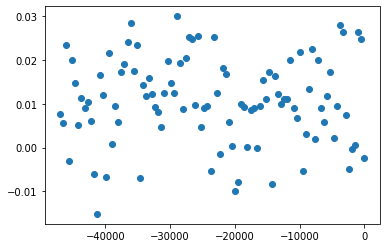

In [155]:
plt.scatter(h_inverse_scaled[0:100]/1000,inverse_scaled_lambda_5000[0:100]/10**(6))

In [ ]:
plt.scatter(h_inverse_scaled[0:100]/1000,inverse_scaled_lambda_5000[0:100]/10**(6))